Author：Ren Yang

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import norm
from scipy.optimize import minimize_scalar   
import pandas as pd
import math
import scipy.stats as st

### Simulate Stock Price
Model: Heston Model With QE Scheme



In [ ]:
delta=1/365
theta=0.04
epsilon=0.5
k=0.1
phi_c=1.2 # Switching Parameter [1,2]
rho=-0.6
C=math.exp(-k*delta)




def QE_V(V_pre):
  # S_sq=(A/k)*(1-C)+(D/2k)*(1-C)^2

  A=V_pre*math.pow(epsilon,2)*C
  D=theta*math.pow(epsilon,2)


  

  # Step 1
  m=theta+(V_pre-theta)*C
  s_sq=(A/k)*(1-C)+(D/(2*k))*math.pow((1-C),2)


  # Step 2
  phi=s_sq/math.pow(m,2)

  # Step 3
  U=np.random.uniform(0,1)
  

  # step 4
  if phi<=phi_c:
    
    # b_sq=E-1+sqrt(E)*sqrt(E-1)
    E=2*(1/phi)
    b_sq=E-1+math.sqrt(E)*math.sqrt(E-1)
    a=m/(1+b_sq)


    Z=st.norm.ppf(U) # generate standard normal R.V using ppf function (inverse of cdf function)

    return a*math.pow((math.sqrt(b_sq)+Z),2)

  
  
  # step 5
  else:

    p=(phi-1)/(phi+1)
    beta=(1-p)/m

    if U>=0 and U<=p:
      return 0
    else:
      return (1/beta)*math.log((1-p)/(1-U))






def QE_X(pre_tuple):

    X_pre=pre_tuple[0]
    V_pre=pre_tuple[1]
   
   # Euler_Like Setting
    y_1=1 
    y_2=0 

   # Can be expaneded to moment matching setting 
    
   #y_1=y_2=0.5 Central setting 



    K_0=-((rho*k*theta)/epsilon)*delta
    K_1=y_1*delta*((k*rho/epsilon)-0.5)-(rho/epsilon)
    K_2=y_2*delta*((k*rho/epsilon)-0.5)+(rho/epsilon)
    K_3=y_1*delta*(1-math.pow(rho,2))
    K_4=y_2*delta*(1-math.pow(rho,2))
   
   
   

    V=QE_V(V_pre)
     

   
    U=np.random.uniform(0,1)
    Z=st.norm.ppf(U)
    
    return (X_pre+K_0+K_1*V_pre+K_2*V+math.sqrt(K_3*V_pre+K_4*V)*Z,V)

In [ ]:
paths_QE=[]
for i in range(1000):
  path=[(math.log(100),0.04)]
  for j in range(365):
    path.append(QE_X(path[-1]))
  price=[math.exp(i[0]) for i in path]
  paths_QE.append(price)

#### Visualize Price Path

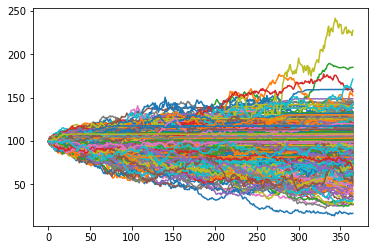

In [ ]:
plt.plot(np.array(paths_QE).T)
plt.show()

#### Visualize End Price Distribution

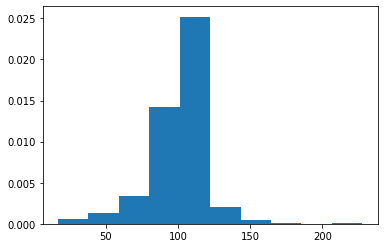

In [ ]:
end_price_QE=[i[-1] for i in paths_QE]
plt.hist(end_price_QE, density=True)
plt.show()

#### Calculate Option Price based on end price distribution across strikes

In [ ]:
def optionPricing(paths,K):
  end_price_QE=[i[-1] for i in paths]
  D_T=math.exp(-0.02)
  sum=0
  for i in end_price_QE:
    sum+=max(D_T*i-D_T*K,0)
  
  return (1/len(end_price_QE))*sum

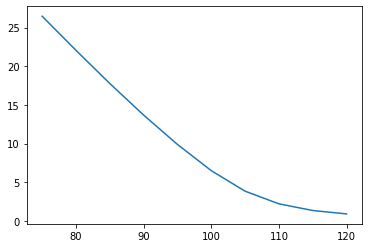

In [ ]:
optionPrice_QE=[optionPricing(paths_QE,K) for K in range(75,125,5)]
plt.plot(list(range(75,125,5)),optionPrice_QE)

### Simulate Stock Price
Model: Heston Model With Euler Scheme



In [ ]:
n=1000
r = 0.02
k=0.1
theta=0.04
e = 0.5
ro = -0.6

s0=100
x0=s0
v0=theta
k=0.2

N =1000
n=365
delta = 1/n

dic_x = {}
dic_v = {}

for num in range(N):

    rand_num1=[]
    for i in range(n): 
        rand_num1.append(random.random())
    rand_num2=[]
    for i in range(n): 
        rand_num2.append(random.random())
    z_v = st.norm.ppf(rand_num1)
    u2_inv = st.norm.ppf(rand_num2)
    z_x = []
    for i in range(n):
        y = ro*z_v[i] + np.sqrt(1-ro**2)*u2_inv[i]
        z_x.append(y)
  
    x_t = x0
    v_t = v0
    x_T = []
    v_T = []
    
    for j in range(n):

        x_t= math.e**(np.log(x_t)-1/2*v_t*delta+np.sqrt(v_t)*z_x[j]*np.sqrt(delta))
        if x_t <=0:
            x_t = 0.000000001
        x_T.append(x_t)
        v_t= v_t +k*(theta-v_t)*delta+e*np.sqrt(v_t)*z_v[j]*np.sqrt(delta)
        if v_t <0:
            v_t = 0
        v_T.append(v_t)
        
    dic_x["x"+str(num+1)] = x_T
    dic_v["v"+str(num+1)] = v_T

#### Visualize Price Path

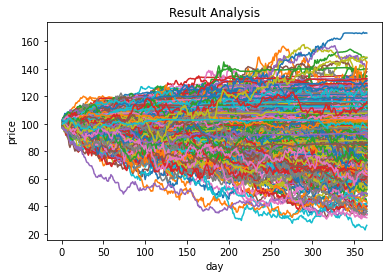

In [ ]:

plt.title('Result Analysis')
x_axix = [i+1 for i in range(n)]
for i in dic_x.values():
    
    plt.plot(x_axix, i)


plt.xlabel('day')
plt.ylabel('price')
plt.show()


#### Calculate Discounted Option Price based on end price distribution across strikes

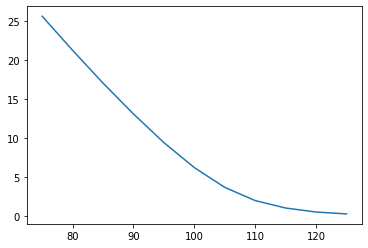

In [ ]:
end_price = []
for i in dic_x.values():
    end_price.append(i[-1])

def option_price(end_price,strike):
    payoff = [i-strike if (i-strike)>0 else 0 for i in end_price]
    return np.mean(payoff)/(math.e**0.02)

dict_option={}

for strike in [i*5+75 for i in range(11)]:
    dict_option['option_price'+str(strike)]=option_price(end_price,strike)


option_value_list=[]
for i in dict_option.values():
    option_value_list.append(i)
plt.plot([i*5+75 for i in range(11)],option_value_list)

### Simulate Stock Price based on BSM Assumptions


under BSM, stock price follows SDE:

$dS_t=rS_tdt+σS_tdW_t$

With Euler Discretization of the SDE, we obtained solution:

$S_{t+Δt}=S_te^{(r-(1/2)σ^2)Δt+\sigma\sqrt{Δt}Z_t} $

In [ ]:
S0 = 100
delta=1/365
num_of_path=1000
total_time_steps=365
r=0.02
sigma=0.2 # constant vol

paths_BSM = S0 * np.exp(np.cumsum((r - 0.5 * sigma ** 2) * delta + sigma * math.sqrt(delta) 
* np.random.standard_normal((total_time_steps + 1, num_of_path)), axis=0))

#

paths_BSM[0] = S0

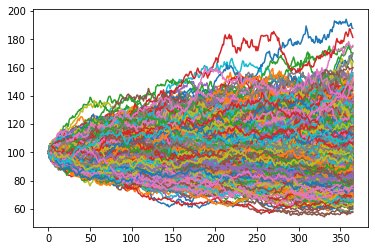

In [ ]:
plt.plot(paths_BSM)
plt.show()

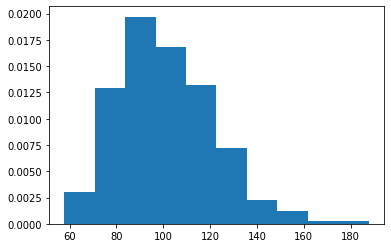

In [ ]:
end_price_BSM=paths_BSM[-1,:]
plt.hist(end_price_BSM, density=True)
plt.show()

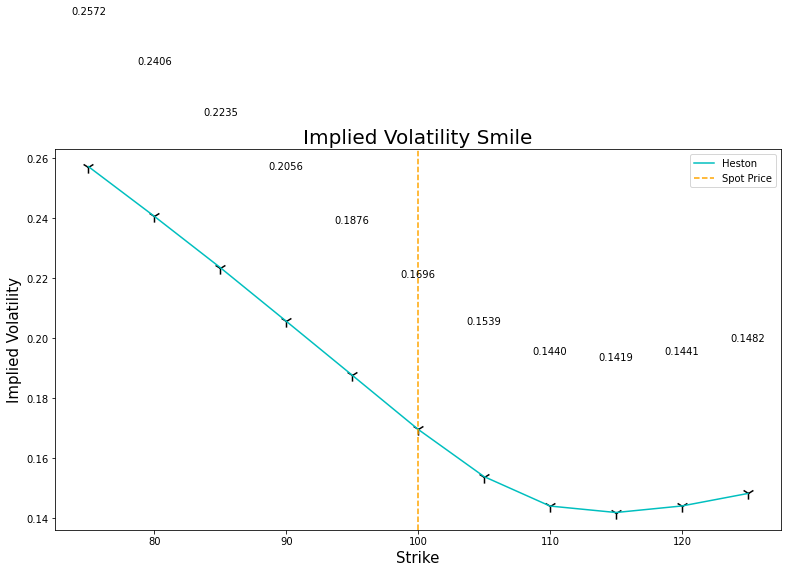

In [ ]:


T = 1
rho = -0.6
r = 0.02
kappa = 0.1
theta = 0.04
xi = 0.5
S0 = 100
K = np.arange(75,126,5)
Npaths = 10000
Nsteps = 252
v0 = 0.04

N = norm.cdf
def heston_simulation(S0, T, r, kappa, theta, v0, rho, xi, Nsteps, Npaths):
    np.random.seed(1)
    
    dt = T / Nsteps
    size = [Npaths, Nsteps]
    S = np.zeros(size)
    V = np.zeros(size)
    S[:,0] = S0
    V[:,0] = v0
    
    for i in range(Nsteps-1):
        W = np.random.multivariate_normal(np.array([0,0]),cov = np.array([[1,rho],[rho,1]]),size = Npaths) * np.sqrt(dt)
        V[:,i+1] = V[:,i] + kappa * (theta - V[:,i]) * dt + xi * np.sqrt(V[:,i]) * W[:,1]
        V[:,i+1] = np.maximum(V[:,i+1],0)
        
        S[:,i+1] = S[:,i] * (np.exp((r - 0.5 * V[:,i]) * dt + np.sqrt(V[:,i]) * W[:,0]))
    return S, V

# Pricing for European Call Option
path, vol = heston_simulation(S0, T, r, kappa, theta, v0, rho, xi, Nsteps, Npaths)
price_path = path[:,-1]

calls = []
for k in K:
    P = np.mean(np.maximum(price_path - k,0))*np.exp(-r*T)
    calls.append(P)

dt = pd.DataFrame(dict(zip(K,calls)),index = ['Price'])
dt

def BS_CALL(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * N(d1) - K * np.exp(-r*T)* N(d2)
       
def implied_vol(opt_value, S, K, T, r):
    
    def call_obj(sigma):
        return abs(BS_CALL(S, K, T, r, sigma) - opt_value)
    
    res = minimize_scalar(call_obj, bounds=(0.01,6), method='bounded')
    return res.x

ivs = [implied_vol(C, S0, k, T, r) for C, k in zip(calls,K)]
plt.figure(figsize = (13,7))
plt.plot(K, ivs, c = 'c', label = 'Heston')
plt.scatter(K, ivs, s = 150, c = 'k', marker = '1')

for a,b in zip(K,ivs):
    plt.text(a, b+0.05, '%.4f' % b, ha='center', va= 'bottom',fontsize = 10)
    
plt.ylabel('Implied Volatility', fontsize = 15)
plt.xlabel('Strike',fontsize = 15)
plt.axvline(S0, color='orange',linestyle='--',label='Spot Price')
plt.title('Implied Volatility Smile', fontsize = 20)
plt.legend()
plt.show()